In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('hn_score_title_10k.csv')
df.title = df.title.str.lower()
df.dropna(inplace= True)
df.head()

,score,title
0,8.0,nasa's 3d-printed rotating detonation rocket e...
1,62.0,heat pumps of the 1800s are becoming the techn...
2,1.0,why you should develop local-first web apps
3,1.0,tool to make twitter archive publishable
4,2.0,fedora packages versus upstream flatpaks


In [3]:
words = []
num_lines = 1000
lines = df.title.tolist()[:num_lines]

for i in df.title[:num_lines]:
    for j in str(i).split():
        if j not in words and j != "nan":
            words.append(j)

vocab_size = len(words)

vocab_size, len(lines)

(3989, 1000)

In [4]:
itos = {num:word for num, word in zip(range(len(words)),words)}
stoi = {word:num for num,word in itos.items()}

In [5]:
def create_skipgram_pairs(input_lines, context_len):
    """
    Generate Skip-Gram pairs (target, context) from a list of input lines.

    Args:
        input_lines (list of str): The input lines of text.
        context_len (int): Context window size (number of words on each side).

    Returns:
        targets (list): List of target words.
        context_words (list of lists): List of context word lists for each target.
    """
    context_words = []
    targets = []

    for line in input_lines:
        # Split the line into words (not letters)
        words = line.split()
        for i, target in enumerate(words):
            # Define context window boundaries
            start = max(0, i - context_len)
            end = min(len(words), i + context_len + 1)

            # Collect context words, excluding the target word itself
            context = [words[j] for j in range(start, end) if j != i]
            targets.append(target)
            context_words.append(context)

            # print(f"Target: {target} ; Context: {context}")

    return targets, context_words

context_len = 1

targets, context_words = create_skipgram_pairs(lines, context_len)

targets_len = len(targets)


In [6]:
# Convert targets to indices
target_indices = [stoi[target] for target in targets if target in stoi]

# Convert context words to indices
context_indices = [[stoi[context] for context in contexts if context in stoi] for contexts in context_words]


In [7]:
# Convert target indices to PyTorch tensor
target_indices = torch.tensor(target_indices, dtype=torch.long)

# Create one-hot encoded targets (X)
X = torch.zeros((targets_len, vocab_size))
X.scatter_(1, target_indices.unsqueeze(1), 1)  # Scatter 1s into the appropriate indices

# Convert context indices to PyTorch tensor and one-hot encode (Y)
Y = torch.zeros((targets_len, vocab_size))
for i, context in enumerate(context_indices):
    Y[i, context] = 1  # Set 1s for all indices in the context for each target

X.shape, Y.shape

(torch.Size([8216, 3989]), torch.Size([8216, 3989]))

In [8]:
emb_dims = 20

W1 = torch.randn(vocab_size, emb_dims)
W2 = torch.randn(vocab_size, emb_dims)

parameters = [W1, W2]

In [9]:
for p in parameters:
    p.requires_grad = True

In [11]:
epochs = 1000
lossi = []

for i in range(epochs):
    h = X @ W1
    logits = h @ W2.T

    # Compute the loss
    loss = F.binary_cross_entropy_with_logits(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    lr = 0.1 if i <= 30000 else 0.01 if i <= 55000 else 0.001
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.item())


      0/   1000: 1.8931
    100/   1000: 1.8874
    200/   1000: 1.8817
    300/   1000: 1.8761
    400/   1000: 1.8706
    500/   1000: 1.8650
    600/   1000: 1.8596
    700/   1000: 1.8541
    800/   1000: 1.8488
    900/   1000: 1.8435


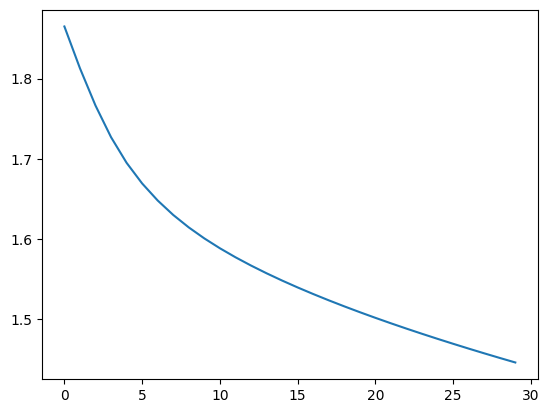

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_nearest_neighbors(word, stoi, embeddings, n=5):
    """
    Find the top-n nearest neighbors of a word in the embedding space.
    
    Args:
        word (str): The target word.
        stoi (dict): Mapping from words to indices.
        embeddings (torch.Tensor): Learned word embeddings (shape: V x d).
        n (int): Number of nearest neighbors to retrieve.
    
    Returns:
        List of tuples (neighbor_word, similarity_score).
    """
    if word not in stoi:
        return f"'{word}' not in vocabulary."
    
    word_idx = stoi[word]
    word_embedding = embeddings[word_idx].unsqueeze(0)  # Shape: 1 x d
    
    # Compute cosine similarity between the target embedding and all embeddings
    similarities = cosine_similarity(word_embedding.detach().numpy(), embeddings.detach().numpy())
    similarities = similarities[0]  # Flatten
    
    # Get top-n similar words (excluding the word itself)
    nearest_indices = similarities.argsort()[-n-1:][::-1][1:]  # Exclude the word itself
    nearest_words = [(list(stoi.keys())[idx], similarities[idx]) for idx in nearest_indices]
    return nearest_words

# Example usage
word = "rocket"
nearest_neighbors = get_nearest_neighbors(word, stoi, W1, n=5)
print(f"Nearest neighbors of '{word}':")
print(nearest_neighbors)


Nearest neighbors of 'rocket':
[('guardsman', 0.6874943), ('spreading', 0.68435574), ('solutions', 0.68200964), ('douglas', 0.66121185), ('cz', 0.61781037)]


In [ ]:
words[:20]

["nasa's",
 '3d-printed',
 'rotating',
 'detonation',
 'rocket',
 'engine',
 'test',
 'a',
 'success',
 'heat',
 'pumps',
 'of',
 'the',
 '1800s',
 'are',
 'becoming',
 'technology',
 'future',
 'why',
 'you']